In [7]:
# Load libraries

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import os
import json
import sys
from datetime import datetime
import matplotlib.dates as mdates
from matplotlib.dates import MO  # Monday as start of week

# Append utils to path for logo import
sys.path.append("utils")
from logo import add_logo

date = 'April 14th, 2025'


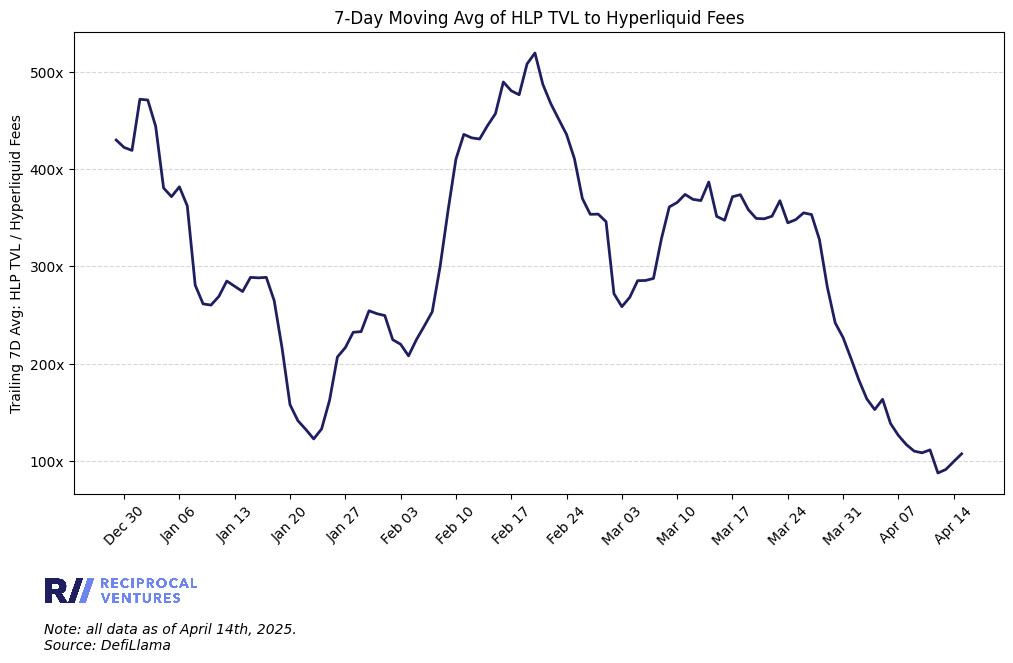

          date           tvl     fees  tvl-to-fees  tvl-to-fees-7d
103 2025-04-06  1.595744e+08  1772829    90.011170      138.553810
104 2025-04-07  1.568473e+08  3117000    50.319942      126.304420
105 2025-04-08  1.499814e+08  1746313    85.884597      116.903407
106 2025-04-09  1.482302e+08  2837027    52.248431      110.154291
107 2025-04-10  1.498008e+08  1686123    88.843334      108.456529
108 2025-04-11  1.495930e+08  1327396   112.696559      111.473799
109 2025-04-12  1.559157e+08  1164323   133.911057       87.702156
110 2025-04-13  1.576559e+08  1365048   115.494737       91.342665
111 2025-04-14  1.598938e+08  1491560   107.199012       99.468247
112 2025-04-15  1.603078e+08  1132766   141.518875      107.416001


In [8]:
# HLP TVL / Hyperliquid total fees multiple

# Load Hyperliquid fees data
with open("raw-data/defillama_hyperliquid-fees.json", "r") as f:
    fee_data = json.load(f)

fee_df = pd.DataFrame(fee_data["totalDataChart"], columns=["timestamp", "fees"])
fee_df["date"] = pd.to_datetime(fee_df["timestamp"], unit="s")
fee_df = fee_df[["date", "fees"]]

# Load HLP TVL data
with open("raw-data/defillama_HLP.json", "r") as f:
    hlp_data = json.load(f)

hlp_raw = hlp_data["chainTvls"]["Hyperliquid"]["tvl"]
hlp_df = pd.DataFrame(hlp_raw)
hlp_df["date"] = pd.to_datetime(hlp_df["date"], unit="s")
hlp_df = hlp_df.rename(columns={"totalLiquidityUSD": "tvl"})
hlp_df = hlp_df[["date", "tvl"]]

# Merge datasets
df = pd.merge(hlp_df, fee_df, on="date", how="inner")
df["tvl-to-fees"] = df["tvl"] / df["fees"]

# Calculate trailing 7-day average
df["tvl-to-fees-7d"] = df["tvl-to-fees"].rolling(window=7).mean()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df["date"], df["tvl-to-fees-7d"], color="#1f1f60", linewidth=2, label="7D Avg")

# X-axis formatting for weekly ticks
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Y-axis formatting
ax.set_ylabel("Trailing 7D Avg: HLP TVL / Hyperliquid Fees")
ax.set_title("7-Day Moving Avg of HLP TVL to Hyperliquid Fees")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:,.0f}x'))

# X-axis formatting: show ticks weekly, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)

plt.grid(axis='y', linestyle='--', alpha=0.5)
add_logo(ax, position=(0.05, -0.21))
plt.figtext(0.1, -0.15, f"Note: all data as of {date}.\nSource: DefiLlama", ha='left', fontsize=10, style='italic')

# Save plot
if not os.path.exists("plots"):
    os.makedirs("plots")
plt.savefig("plots/tvl-to-fees_ratio_7d_avg.png", dpi=300, bbox_inches='tight')
plt.show()

# Print sample of the dataset with 7D average
print(df[["date", "tvl", "fees", "tvl-to-fees", "tvl-to-fees-7d"]].tail(10))

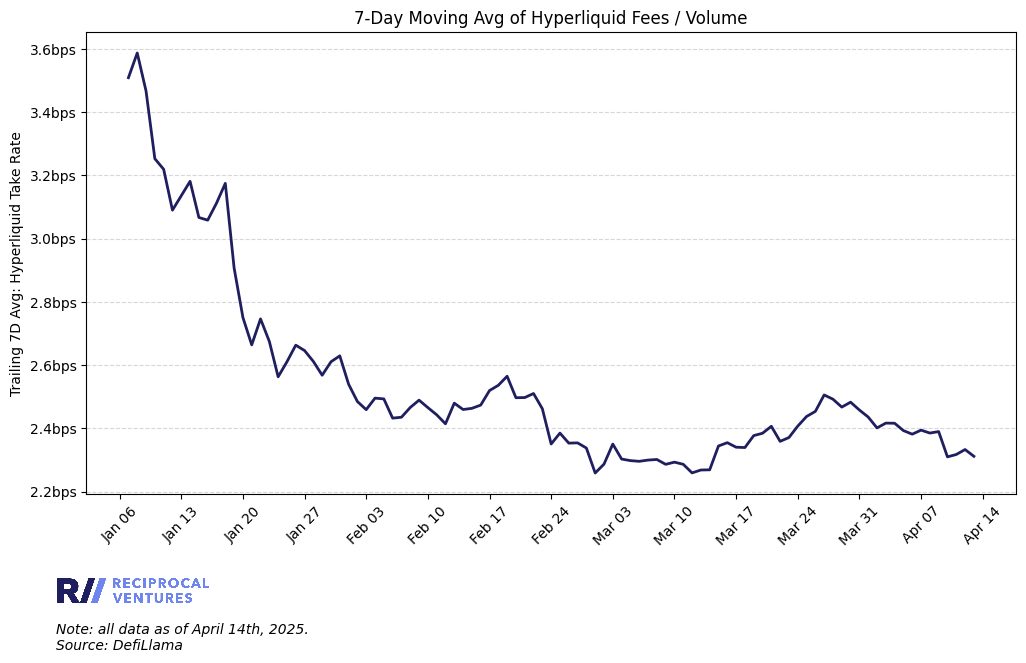

          date     fees       volumes  take-rate  take-rate-7d
93  2025-04-05   545156  2.430774e+09   2.242726      2.392919
94  2025-04-06  1772829  7.538398e+09   2.351732      2.381593
95  2025-04-07  3117000  1.330997e+10   2.341853      2.394353
96  2025-04-08  1746313  7.663480e+09   2.278747      2.385129
97  2025-04-09  2837027  1.244462e+10   2.279722      2.389800
98  2025-04-10  1686123  7.229337e+09   2.332334      2.309830
99  2025-04-11  1327396  5.544363e+09   2.394136      2.317321
100 2025-04-12  1164323  4.949383e+09   2.352461      2.332998
101 2025-04-13  1365048  6.199138e+09   2.201996      2.311607
102 2025-04-14  1491560           NaN        NaN           NaN


In [10]:
# HLP TVL / Hyperliquid total fees multiple

# Load Hyperliquid fees data
with open("raw-data/defillama_hyperliquid-fees.json", "r") as f:
    fee_data = json.load(f)

fee_df = pd.DataFrame(fee_data["totalDataChart"], columns=["timestamp", "fees"])
fee_df["date"] = pd.to_datetime(fee_df["timestamp"], unit="s")
fee_df = fee_df[["date", "fees"]]

# Load Hyperliquid volume data
volume_df = pd.read_csv('raw-data/artemis_perps-trading-volume.csv')
volume_df['Date'] = pd.to_datetime(volume_df['Date'], format='%d-%b-%y')
volume_df.rename(columns={'Date': 'date', 'Hyperliquid': 'volumes'}, inplace=True)

# Merge datasets
df = pd.merge(volume_df, fee_df, on="date", how="inner")
df["take-rate"] = df["fees"] / df["volumes"] * 10000 # Convert to BPS

# Calculate trailing 7-day average
df["take-rate-7d"] = df["take-rate"].rolling(window=7).mean()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df["date"], df["take-rate-7d"], color="#1f1f60", linewidth=2, label="7D Avg")

# X-axis formatting for weekly ticks
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))


# Y-axis formatting
ax.set_ylabel("Trailing 7D Avg: Hyperliquid Take Rate")
ax.set_title("7-Day Moving Avg of Hyperliquid Fees / Volume")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.1f}bps'))

# X-axis formatting: show ticks weekly, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)

plt.grid(axis='y', linestyle='--', alpha=0.5)
add_logo(ax, position=(0.05, -0.21))
plt.figtext(0.1, -0.15, f"Note: all data as of {date}.\nSource: DefiLlama", ha='left', fontsize=10, style='italic')

# Save plot
if not os.path.exists("plots"):
    os.makedirs("plots")
plt.savefig("plots/take-rate_7d_avg.png", dpi=300, bbox_inches='tight')
plt.show()

# Print sample of the dataset with 7D average
print(df[["date", "fees", "volumes", "take-rate", "take-rate-7d"]].tail(10))